In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer

In [ ]:
file_path = '/content/drive/MyDrive/data/bitcoin/data_raw/bitcoin_trend_data_day.csv'
df = pd.read_csv(file_path)

df.head()

,timestamp,open,high,low,close,volume,trend
0,1/1/2021,28923.63,29600.00,28624.57,29331.69,54182.92501,1
1,2/1/2021,29331.70,33300.00,28946.53,32178.33,129993.87340,1
2,3/1/2021,32176.45,34778.11,31962.99,33000.05,120957.56680,1
3,4/1/2021,33000.05,33600.00,28130.00,31988.71,140899.88570,1
4,5/1/2021,31989.75,34360.00,29900.00,33949.53,116049.99700,1


In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

timestamp    0
open         0
high         0
low          0
close        0
volume       0
trend        0
dtype: int64


In [ ]:
trend_label_counts = df['trend'].value_counts()
print(trend_label_counts)

trend
1    780
0    461
Name: count, dtype: int64


In [ ]:
# Convert timestamp to datetime with a specific format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y', errors='coerce')

# Calculate Moving Averages (MA)
df['MA_7'] = df['close'].rolling(window=7).mean()
df['MA_25'] = df['close'].rolling(window=25).mean()
df['MA_99'] = df['close'].rolling(window=99).mean()

# Calculate Exponential Moving Averages (EMA)
df['EMA_7'] = df['close'].ewm(span=7, adjust=False).mean()
df['EMA_30'] = df['close'].ewm(span=30, adjust=False).mean()

# Calculate MACD and Signal Line
df['MACD'] = df['EMA_7'] - df['EMA_30']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Calculate RSI
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_6'] = calculate_rsi(df['close'], 6)
df['RSI_14'] = calculate_rsi(df['close'], 14)

# Save the updated dataframe to a new CSV file
output_file = '/content/bitcoin_trend_data_with_indicators.csv'
df.to_csv(output_file, index=False)

print(f"Indicators calculated and saved to '{output_file}'")

Indicators calculated and saved to '/content/bitcoin_trend_data_with_indicators.csv'


In [3]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/data/bitcoin/data_processed/bitcoin_trend_data_with_indicators.csv')

# Function to parse mixed date formats
def parse_mixed_dates(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y')
    except ValueError:
        return pd.to_datetime(date_str, format='%m/%d/%Y')

# Convert timestamp to datetime with specific format
df['timestamp'] = df['timestamp'].apply(parse_mixed_dates)

In [4]:
# Define input features and target
features = ['close', 'MA_7', 'MA_25', 'MA_99', 'EMA_7', 'EMA_30', 'MACD', 'Signal_Line', 'RSI_6', 'RSI_14']
X = df[features]
y = df['trend']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

In [5]:
# Function to train and evaluate model
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

In [ ]:
# Logistic Regression
logistic_model = LogisticRegression()
logistic_accuracy, logistic_report = train_evaluate_model(logistic_model, X_train_scaled, y_train, X_test_scaled, y_test)
print('Logistic Regression')
print(f'Accuracy: {logistic_accuracy}')
print('Classification Report:')
print(logistic_report)

Logistic Regression
Accuracy: 0.8502024291497976
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79        99
           1       0.82      0.96      0.88       148

    accuracy                           0.85       247
   macro avg       0.87      0.82      0.84       247
weighted avg       0.86      0.85      0.85       247



In [7]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_accuracy, rf_report = train_evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test)
print('Random Forest')
print(f'Accuracy: {rf_accuracy}')
print('Classification Report:')
print(rf_report)

Random Forest
Accuracy: 0.9880952380952381
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.98      0.99       152

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252



In [6]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_accuracy, gb_report = train_evaluate_model(gb_model, X_train_scaled, y_train, X_test_scaled, y_test)
print('Gradient Boosting')
print(f'Accuracy: {gb_accuracy}')
print('Classification Report:')
print(gb_report)

Gradient Boosting
Accuracy: 0.9801587301587301
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.99      0.98      0.98       152

    accuracy                           0.98       252
   macro avg       0.98      0.98      0.98       252
weighted avg       0.98      0.98      0.98       252



In [ ]:
# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_accuracy, xgb_report = train_evaluate_model(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test)
print('XGBoost')
print(f'Accuracy: {xgb_accuracy}')
print('Classification Report:')
print(xgb_report)

XGBoost
Accuracy: 0.9878542510121457
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        99
           1       0.99      0.99      0.99       148

    accuracy                           0.99       247
   macro avg       0.99      0.99      0.99       247
weighted avg       0.99      0.99      0.99       247



In [ ]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the LSTM model on the test set
lstm_y_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")
lstm_accuracy = accuracy_score(y_test, lstm_y_pred)
lstm_report = classification_report(y_test, lstm_y_pred)

print('LSTM Model')
print(f'Accuracy: {lstm_accuracy}')
print('Classification Report:')
print(lstm_report)

Epoch 1/100
25/25 [==============================] - 5s 56ms/step - loss: 0.5595 - accuracy: 0.7423 - val_loss: 0.4869 - val_accuracy: 0.7908
Epoch 2/100
25/25 [==============================] - 0s 15ms/step - loss: 0.4271 - accuracy: 0.8227 - val_loss: 0.4595 - val_accuracy: 0.7806
Epoch 3/100
25/25 [==============================] - 0s 14ms/step - loss: 0.3775 - accuracy: 0.8418 - val_loss: 0.4249 - val_accuracy: 0.7857
Epoch 4/100
25/25 [==============================] - 0s 15ms/step - loss: 0.3603 - accuracy: 0.8367 - val_loss: 0.3755 - val_accuracy: 0.8469
Epoch 5/100
25/25 [==============================] - 1s 21ms/step - loss: 0.3214 - accuracy: 0.8597 - val_loss: 0.3841 - val_accuracy: 0.8367
Epoch 6/100
25/25 [==============================] - 1s 22ms/step - loss: 0.3222 - accuracy: 0.8431 - val_loss: 0.3953 - val_accuracy: 0.8214
Epoch 7/100
25/25 [==============================] - 1s 22ms/step - loss: 0.2866 - accuracy: 0.8571 - val_loss: 0.3070 - val_accuracy: 0.8469
Epoch 

In [ ]:
# Define the GRU model
gru_model = Sequential()
gru_model.add(GRU(200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(200, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the GRU model
gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the GRU model on the test set
gru_y_pred = (gru_model.predict(X_test) > 0.5).astype("int32")
gru_accuracy = accuracy_score(y_test, gru_y_pred)
gru_report = classification_report(y_test, gru_y_pred)

print('GRU Model')
print(f'Accuracy: {gru_accuracy}')
print('Classification Report:')
print(gru_report)

Epoch 1/100
25/25 [==============================] - 11s 83ms/step - loss: 0.4739 - accuracy: 0.7449 - val_loss: 0.4591 - val_accuracy: 0.7959
Epoch 2/100
25/25 [==============================] - 1s 50ms/step - loss: 0.3848 - accuracy: 0.8112 - val_loss: 0.4158 - val_accuracy: 0.8265
Epoch 3/100
25/25 [==============================] - 1s 50ms/step - loss: 0.3711 - accuracy: 0.8176 - val_loss: 0.3955 - val_accuracy: 0.8214
Epoch 4/100
25/25 [==============================] - 1s 50ms/step - loss: 0.3601 - accuracy: 0.8329 - val_loss: 0.3880 - val_accuracy: 0.8367
Epoch 5/100
25/25 [==============================] - 1s 49ms/step - loss: 0.3270 - accuracy: 0.8469 - val_loss: 0.3482 - val_accuracy: 0.8418
Epoch 6/100
25/25 [==============================] - 2s 93ms/step - loss: 0.3008 - accuracy: 0.8559 - val_loss: 0.3153 - val_accuracy: 0.8571
Epoch 7/100
25/25 [==============================] - 2s 92ms/step - loss: 0.2798 - accuracy: 0.8686 - val_loss: 0.3241 - val_accuracy: 0.8418
Epoch

In [ ]:
# Load the dataset with indicators
df = pd.read_csv('/content/drive/MyDrive/data/bitcoin/data_raw/bitcoin_daily_data_2018.csv')
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y', errors='coerce')

# Calculate Moving Averages (MA)
df['MA_7'] = df['close'].rolling(window=7).mean()
df['MA_25'] = df['close'].rolling(window=25).mean()
df['MA_99'] = df['close'].rolling(window=99).mean()

# Calculate Exponential Moving Averages (EMA)
df['EMA_7'] = df['close'].ewm(span=7, adjust=False).mean()
df['EMA_30'] = df['close'].ewm(span=30, adjust=False).mean()

# Calculate MACD and Signal Line
df['MACD'] = df['EMA_7'] - df['EMA_30']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Calculate RSI
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_6'] = calculate_rsi(df['close'], 6)
df['RSI_14'] = calculate_rsi(df['close'], 14)

# Save the updated dataframe to a new CSV file
output_file = '/content/bitcoin_daily_data_2018_with_indicators.csv'
df.to_csv(output_file, index=False)

print(f"Indicators calculated and saved to '{output_file}'")

Indicators calculated and saved to '/content/bitcoin_daily_data_2018_with_indicators.csv'


In [ ]:
# Load the original training dataset
training_df = pd.read_csv('/content/drive/MyDrive/data/bitcoin/data_processed/bitcoin_daily_data_2018_with_indicators.csv')

# Convert timestamp to datetime with specific format
training_df['timestamp'] = pd.to_datetime(training_df['timestamp'], format='%d/%m/%Y', errors='coerce')

# Define input features and target for training data
features = ['close', 'MA_7', 'MA_25', 'MA_99', 'EMA_7', 'EMA_30', 'MACD', 'Signal_Line', 'RSI_6', 'RSI_14']
X_train = training_df[features]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_imputed = imputer.transform(df[features])

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_scaled = scaler.transform(X_imputed)

rf_trend_pred = rf_model.predict(X_scaled)

# Prepare data for GRU
X_train_scaled_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))


# Predict trend using GRU model
gru_trend_pred = (gru_model.predict(X_scaled_reshaped) > 0.5).astype("int32")

# Add the predictions to the dataframe
df['RF_Trend_Pred'] = rf_trend_pred
df['GRU_Trend_Pred'] = gru_trend_pred

# Save the predictions to a new CSV file
prediction_file = '/content/bitcoin_daily_data_2018_predictions.csv'
df.to_csv(prediction_file, index=False)

print(f"Predictions saved to '{prediction_file}'")

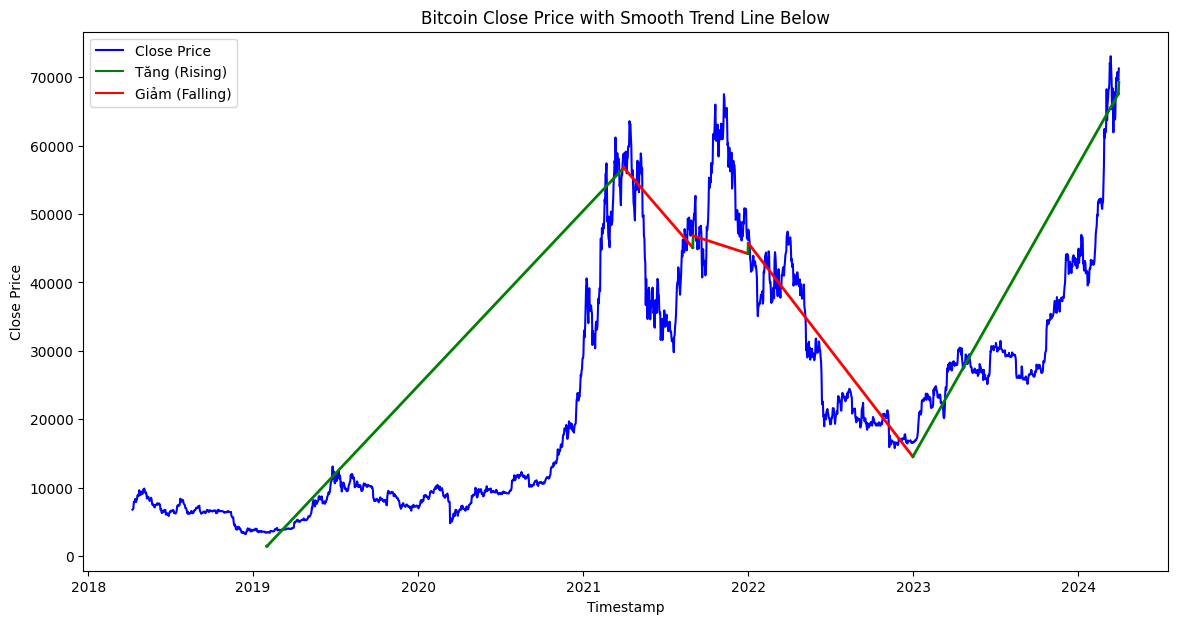

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Plotting the close price with a single line representing the trend changes below the close price line
plt.figure(figsize=(14, 7))
plt.plot(data['timestamp'], data['close'], label='Close Price', color='blue')

# Creating a single line for the trend changes
trend_line_x = []
trend_line_y = []
current_trend = data['trend'][0]
for i in range(1, len(data)):
    if data['trend'][i] != current_trend or i == len(data) - 1:
        x_values = data['timestamp'][i-1:i+1]
        y_values = data['close'][i-1:i+1] - 2000
        if len(x_values) > 1:
            x_values_float = np.array([x.timestamp() for x in x_values])
            if len(x_values_float) > 2:  # Ensure we have enough points for the spline
                spl = make_interp_spline(x_values_float, y_values, k=2)
                x_new = np.linspace(x_values_float[0], x_values_float[-1], 10)
                y_new = spl(x_new)
                x_new = pd.to_datetime(x_new * 1e9)
                trend_line_x.extend(x_new)
                trend_line_y.extend(y_new)
            else:
                trend_line_x.extend(x_values)
                trend_line_y.extend(y_values)
        current_trend = data['trend'][i]

# Plotting the trend line
for i in range(1, len(trend_line_x)):
    color = 'green' if trend_line_y[i] > trend_line_y[i - 1] else 'red'
    plt.plot(trend_line_x[i-1:i+1], trend_line_y[i-1:i+1], color=color, linewidth=2)

# Adding title and labels
plt.title('Bitcoin Close Price with Smooth Trend Line Below')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')

# Adding custom legend
plt.plot([], [], color='green', label='Tăng (Rising)')
plt.plot([], [], color='red', label='Giảm (Falling)')
plt.legend()

# Show the plot
plt.show()


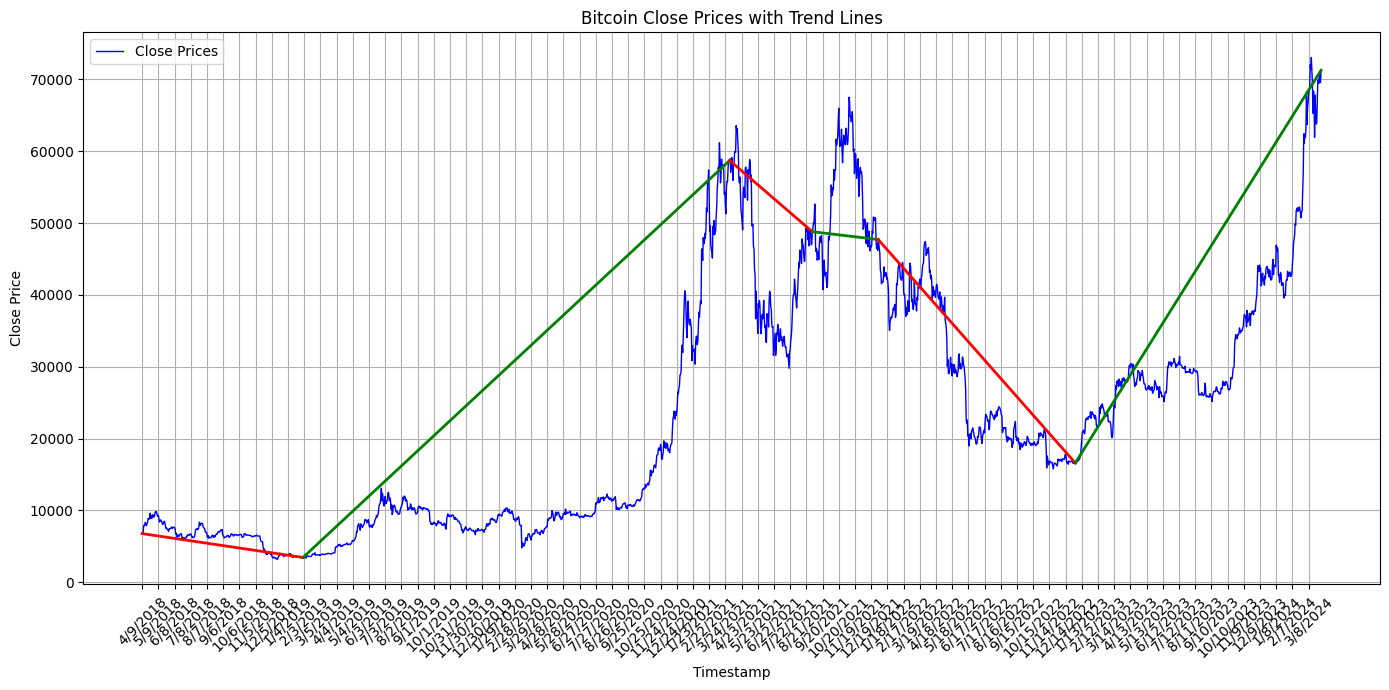

In [ ]:
# Extract necessary columns
close_prices = data['close']
trend = data['trend']
timestamps = data['timestamp']

# Initialize the trend line lists
trend_x = [0]
trend_y = [close_prices[0]]

# Create a combined trend line
for i in range(1, len(trend)):
    if trend[i] != trend[i-1]:
        trend_x.append(i)
        trend_y.append(close_prices[i])

# Append the last point
trend_x.append(len(trend) - 1)
trend_y.append(close_prices[len(trend) - 1])

# Plot the close prices
plt.figure(figsize=(14, 7))
plt.plot(timestamps, close_prices, label='Close Prices', color='blue', linewidth=1)

# Plot the combined trend line with color changes
for i in range(1, len(trend_x)):
    segment_x = np.array(timestamps)[[trend_x[i-1], trend_x[i]]]
    segment_y = [trend_y[i-1], trend_y[i]]
    if trend[trend_x[i-1]] == 1:
        plt.plot(segment_x, segment_y, color='green', linewidth=2, linestyle='-')
    else:
        plt.plot(segment_x, segment_y, color='red', linewidth=2, linestyle='-')

plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Prices with Trend Lines')
plt.legend()
plt.xticks(np.arange(0, len(timestamps), step=30), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


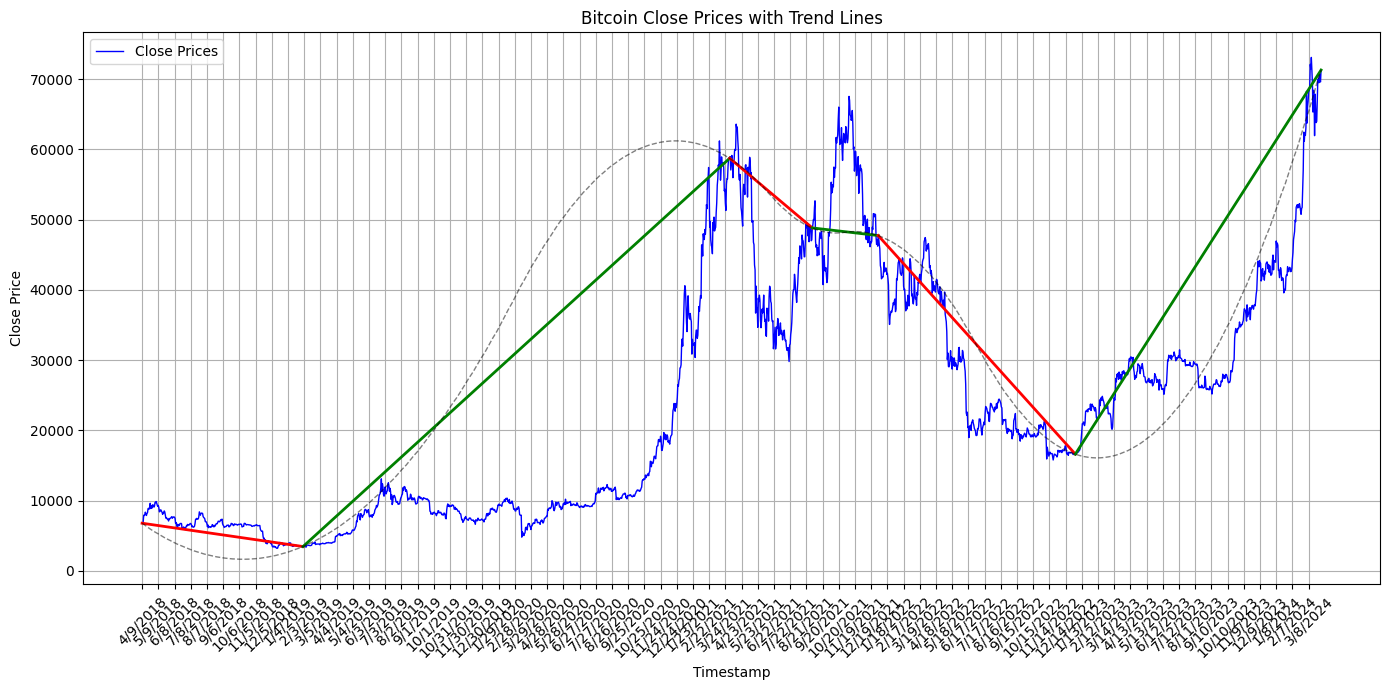

In [ ]:
# Extract necessary columns
close_prices = data['close']
trend = data['trend']
timestamps = data['timestamp']

# Initialize the trend line lists
trend_x = [0]
trend_y = [close_prices[0]]

# Create a combined trend line
for i in range(1, len(trend)):
    if trend[i] != trend[i-1]:
        trend_x.append(i)
        trend_y.append(close_prices[i])

# Append the last point
trend_x.append(len(trend) - 1)
trend_y.append(close_prices[len(trend) - 1])

# Smooth the trend line with more points for a rounded effect
xnew = np.linspace(trend_x[0], trend_x[-1], 300)
spl = make_interp_spline(trend_x, trend_y, k=2)  # k=2 for a rounded effect
smooth_y = spl(xnew)

# Plot the close prices
plt.figure(figsize=(14, 7))
plt.plot(timestamps, close_prices, label='Close Prices', color='blue', linewidth=1)

# Plot the combined trend line with color changes
for i in range(1, len(trend_x)):
    segment_x = np.array(timestamps)[[trend_x[i-1], trend_x[i]]]
    segment_y = [trend_y[i-1], trend_y[i]]
    if trend[trend_x[i-1]] == 1:
        plt.plot(segment_x, segment_y, color='green', linewidth=2, linestyle='-')
    else:
        plt.plot(segment_x, segment_y, color='red', linewidth=2, linestyle='-')

# Plot the smoothed trend line
plt.plot(np.array(timestamps)[np.linspace(0, len(timestamps) - 1, 300).astype(int)], smooth_y, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Prices with Trend Lines')
plt.legend()
plt.xticks(np.arange(0, len(timestamps), step=30), rotation=45) # Adjust the step for readability
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
file_path = '/content/bitcoin_daily_data_test.csv'
df = pd.read_csv(file_path)

In [ ]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y', errors='coerce')

# Calculate Moving Averages (MA)
df['MA_7'] = df['close'].rolling(window=7).mean()
df['MA_25'] = df['close'].rolling(window=25).mean()
df['MA_99'] = df['close'].rolling(window=99).mean()

# Calculate Exponential Moving Averages (EMA)
df['EMA_7'] = df['close'].ewm(span=7, adjust=False).mean()
df['EMA_30'] = df['close'].ewm(span=30, adjust=False).mean()

# Calculate MACD and Signal Line
df['MACD'] = df['EMA_7'] - df['EMA_30']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Calculate RSI
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_6'] = calculate_rsi(df['close'], 6)
df['RSI_14'] = calculate_rsi(df['close'], 14)

# Save the updated dataframe to a new CSV file
output_file = '/content/bitcoin_daily_data_test_with_indicators.csv'
df.to_csv(output_file, index=False)

print(f"Indicators calculated and saved to '{output_file}'")

Indicators calculated and saved to '/content/bitcoin_daily_data_test_with_indicators.csv'


In [9]:
# Load the original training dataset
training_df = pd.read_csv('/content/drive/MyDrive/data/bitcoin/data_processed/bitcoin_trend_data_with_indicators.csv')

# Define input features and target for training data
features = ['close', 'MA_7', 'MA_25', 'MA_99', 'EMA_7', 'EMA_30', 'MACD', 'Signal_Line', 'RSI_6', 'RSI_14']
X_train = training_df[features]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_imputed = imputer.transform(df[features])

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_scaled = scaler.transform(X_imputed)

rf_trend_pred = rf_model.predict(X_scaled)

# Prepare data for GRU
X_train_scaled_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Add the predictions to the dataframe
df['RF_Trend_Pred'] = rf_trend_pred

# Save the predictions to a new CSV file
prediction_file = '/content/bitcoin_daily_data_test_predictions.csv'
df.to_csv(prediction_file, index=False)

print(f"Predictions saved to '{prediction_file}'")

Predictions saved to '/content/bitcoin_daily_data_test_predictions1.csv'


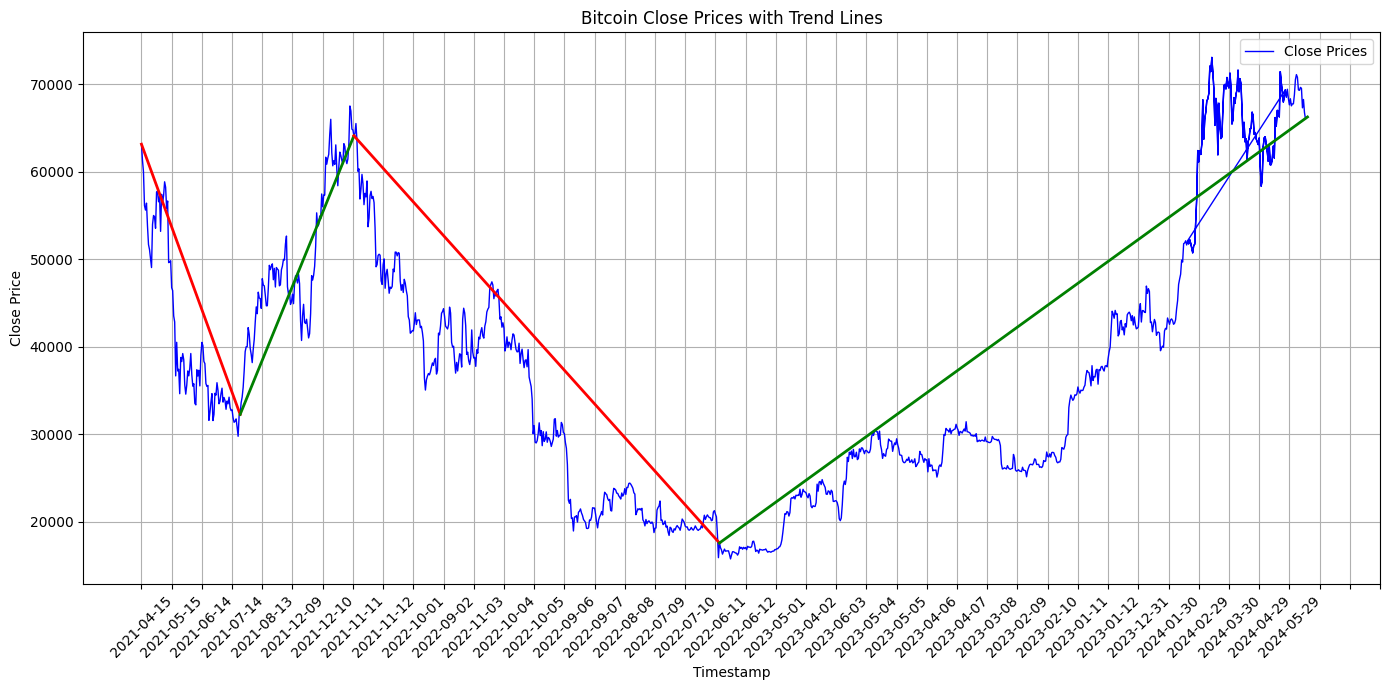

In [10]:
data = pd.read_csv('/content/bitcoin_daily_data_test_predictions.csv')

# Extract necessary columns
close_prices = data['close']
trend = data['trend']
timestamps = data['timestamp']

# Initialize the trend line lists
trend_x = [0]
trend_y = [close_prices[0]]

# Create a combined trend line
for i in range(1, len(trend)):
    if trend[i] != trend[i-1]:
        trend_x.append(i)
        trend_y.append(close_prices[i])

# Append the last point
trend_x.append(len(trend) - 1)
trend_y.append(close_prices[len(trend) - 1])

# Plot the close prices
plt.figure(figsize=(14, 7))
plt.plot(timestamps, close_prices, label='Close Prices', color='blue', linewidth=1)

# Plot the combined trend line with color changes
for i in range(1, len(trend_x)):
    segment_x = np.array(timestamps)[[trend_x[i-1], trend_x[i]]]
    segment_y = [trend_y[i-1], trend_y[i]]
    if trend[trend_x[i-1]] == 1:
        plt.plot(segment_x, segment_y, color='green', linewidth=2, linestyle='-')
    else:
        plt.plot(segment_x, segment_y, color='red', linewidth=2, linestyle='-')

plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Prices with Trend Lines')
plt.legend()
plt.xticks(np.arange(0, len(timestamps), step=30), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
